The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image (“birds-eye view”).
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
# import matplotlib
# matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
# %matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
print(images)
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

['./camera_cal\\calibration1.jpg', './camera_cal\\calibration10.jpg', './camera_cal\\calibration11.jpg', './camera_cal\\calibration12.jpg', './camera_cal\\calibration13.jpg', './camera_cal\\calibration14.jpg', './camera_cal\\calibration15.jpg', './camera_cal\\calibration16.jpg', './camera_cal\\calibration17.jpg', './camera_cal\\calibration18.jpg', './camera_cal\\calibration19.jpg', './camera_cal\\calibration2.jpg', './camera_cal\\calibration20.jpg', './camera_cal\\calibration3.jpg', './camera_cal\\calibration4.jpg', './camera_cal\\calibration5.jpg', './camera_cal\\calibration6.jpg', './camera_cal\\calibration7.jpg', './camera_cal\\calibration8.jpg', './camera_cal\\calibration9.jpg']


In [3]:
plt.get_backend()

'module://ipykernel.pylab.backend_inline'

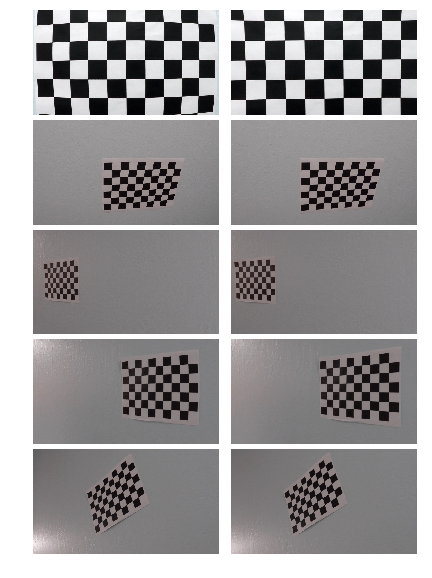

In [2]:
import os
import matplotlib.gridspec as gridspec
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
fig = plt.figure(figsize=(7,10))
i=0
gs1 = gridspec.GridSpec(5, 2)
gs1.update(wspace=0.025, hspace=0.05)
for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # plt.subplot()
    # cv2.imshow('img',dst)
    # cv2.waitKey(1000)
    if i < 10:
        plt.subplot(gs1[i])
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(gs1[i+1])
        plt.imshow(dst)
        plt.axis('off')
        i+=2
plt.savefig('./output_images/undistorted_subplot')
plt.show()
for fname in images:
   img = cv2.imread(fname)
   dst = cv2.undistort(img, mtx, dist, None, mtx)
   # print('./output_images/undistorted_{0}'.format(os.path.basename(fname)))
   cv2.imwrite('./output_images/undistorted_{0}'.format(os.path.basename(fname)),dst)

cv2.destroyAllWindows()

In [ ]:
if len(images) != len(imgpoints):
    raise RuntimeError("I have {0} images but found {1} imgpoints - check your images in first cell")
offset = 50
img_size = gray.shape[::-1]
for i, fname in enumerate(images):
    # corners matching current image
    corners = imgpoints[i]
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    dst = np.float32([[offset, offset], 
                      [img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]-offset], 
                      [offset, img_size[1]-offset]
                      ])

In [3]:
undistorted_images = glob.glob('./output_images/undistorted_calibration*.jpg')
offset = 100
img_size = gray.shape[::-1]  # assuming that all images have the same dimensions
for fname in undistorted_images:
    undist = cv2.imread(fname)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret is True:

        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset],
                          [img_size[0]-offset, offset],
                          [img_size[0]-offset, img_size[1]-offset],
                          [offset, img_size[1]-offset]
                          ])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)
        cv2.imshow('warped image', warped)
        cv2.waitKey(500)
    else:
        print('WARNING: some corners lost during undistortion for image {0}'.format(os.path.basename(fname)))
    # If found, add object points, image points
    # if ret == True:
    #     # objpoints.append(objp)
    #     # imgpoints.append(corners)
    # 
    #     # Draw and display the corners
    #     
    #     img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    #     cv2.imshow('img',img)
    #     cv2.waitKey(500)

cv2.destroyAllWindows()

In [ ]:
images = glob.glob('./output_images/undistorted_calibration*.jpg')

for fname in undistorted_images:
    img = cv2.imread(fname)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

saving to ./output_images/pipeline_undist_straight_lines1.jpg


saving to ./output_images/pipeline_undist_straight_lines2.jpg


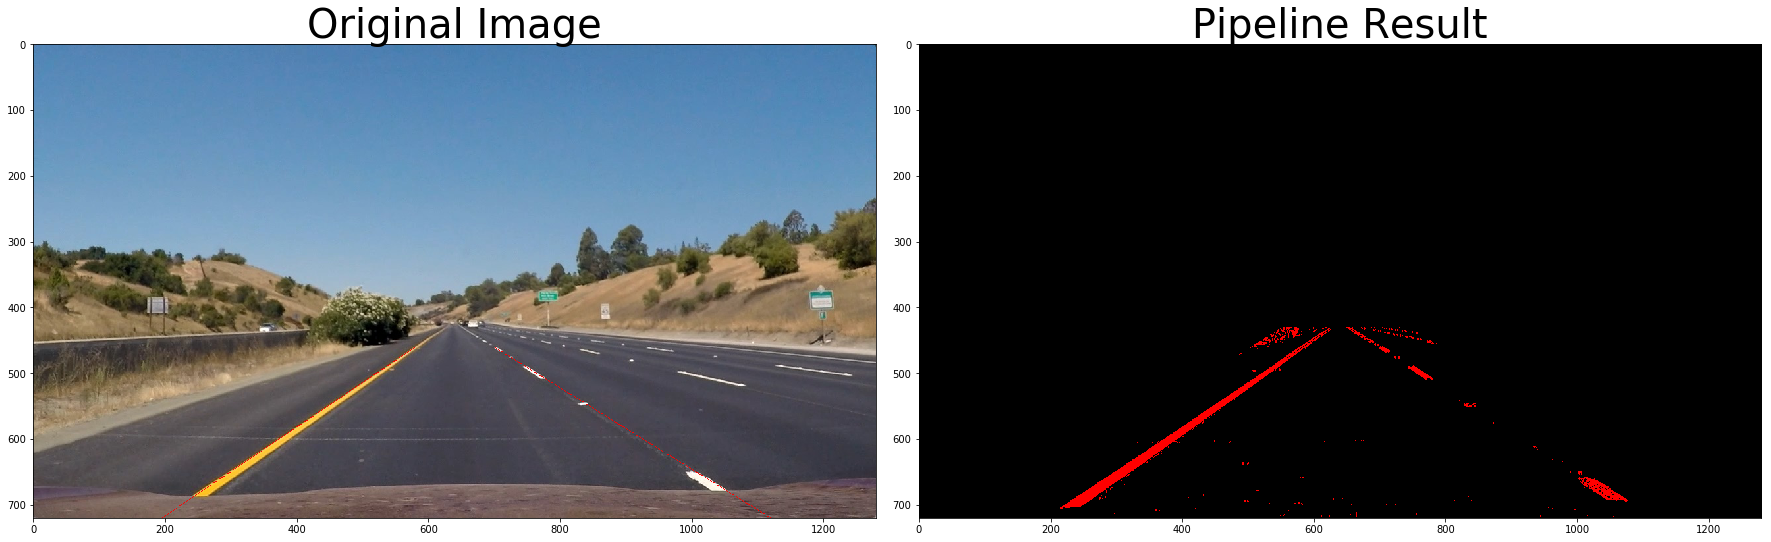

In [4]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (1,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS).astype(np.float)
    # hsv = cv2.cvtColor(undist, cv2.COLOR_BGR2HSV).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # np.dstack(np.zeros_like(s_binary), sxbinary, s_binary)
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    third_layer = np.zeros_like(sxbinary)
    third_layer = (sxbinary + s_binary)
    third_layer[(third_layer >= 1)] = 1
    third_layer = region_of_interest(third_layer, 
            [np.array([[100, image.shape[0]], [550, 430], [750, 430], [image.shape[1]-100, image.shape[0]]])])
    sxbinary = np.zeros_like(sxbinary)
    s_binary = np.zeros_like(sxbinary)
    # cv2.polylines(sxbinary, 
    #               [np.array([[195, image.shape[0]], [623, 430], [655, 430], [image.shape[1]-160, image.shape[0]]])],
    #               True,
    #               1
    #               )
    color_binary = np.dstack((third_layer, sxbinary, s_binary))
    return color_binary
    
images = glob.glob('./test_images/straight*')
for fname in images:
    image = cv2.imread(fname)
    result = pipeline(image, (190, 255), (20, 150))
    # fig = plt.figure()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    # cv2.polylines(image, 
    #               [np.array([[195, image.shape[0]], [623, 430], [655, 430], [image.shape[1]-160, image.shape[0]]])],
    #               True,
    #               (0, 0, 255)
    #               )    
    cv2.polylines(image, 
                  [np.array([[195, image.shape[0]], [580, 460], [700, 460], [image.shape[1]-160, image.shape[0]]])],
                  True,
                  (0, 0, 255)
                  )
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=40)
    
    ax2.imshow(result)
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    print('saving to ./output_images/pipeline_undist_{0}'.format(os.path.basename(fname)))
    plt.savefig('./output_images/pipeline_undist_{0}'.format(os.path.basename(fname)))

In [5]:
offset = 300
img_size = gray.shape[::-1]
print(img_size)
src = np.float32([[195, image.shape[0]], 
                [623, 430], 
                [655, 430], 
                [image.shape[1]-160, image.shape[0]]
                ])
src = np.float32([[580, 460], [700, 460], [1120, 720], [195, 720]])
dst = np.float32([
                  
                  [offset, 0],
                  [image.shape[1]-offset, 0],
                  [image.shape[1]-offset, image.shape[0]],
                  [offset, image.shape[0]],
                  ])
dst = np.float32([[300, 0],
                  [960, 0],
                  [960, 700],
                  [300, 700],
                ])
print(dst)
M = cv2.getPerspectiveTransform(src, dst)
print(M)
warped = cv2.warpPerspective(image, M, img_size)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted and warped', fontsize=40)
plt.savefig('./output_images/warped.jpg')
cv2.imwrite('./output_images/warped_cv2.jpg',warped)

(1280, 720)
[[ 300.    0.]
 [ 960.    0.]
 [ 960.  700.]
 [ 300.  700.]]
[[ -5.06045414e-01  -1.46151578e+00   9.38201121e+02]
 [ -2.44249065e-15  -1.90946623e+00   8.78354468e+02]
 [ -3.03576608e-18  -2.37393099e-03   1.00000000e+00]]


True

saving to ./output_images/pipeline_processed_test1.jpg


saving to ./output_images/pipeline_processed_test2.jpg


saving to ./output_images/pipeline_processed_test3.jpg


saving to ./output_images/pipeline_processed_test4.jpg


saving to ./output_images/pipeline_processed_test5.jpg


saving to ./output_images/pipeline_processed_test6.jpg


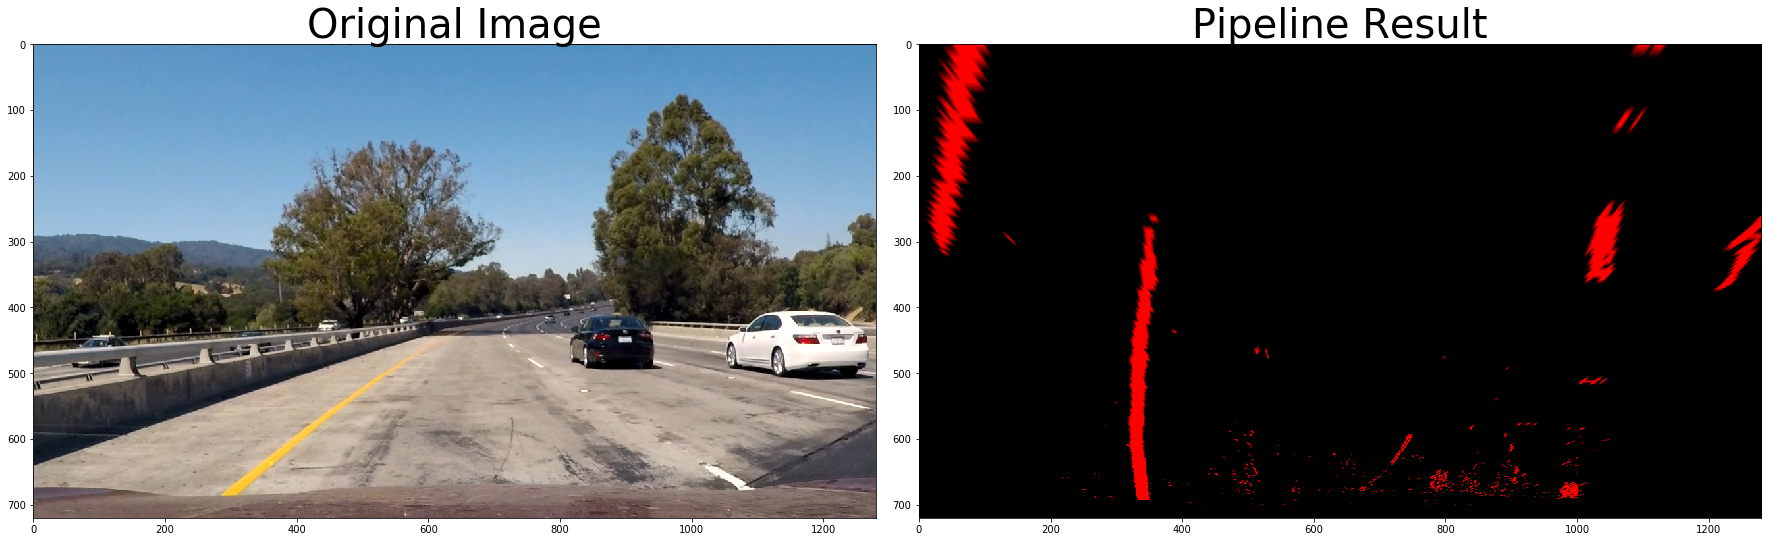

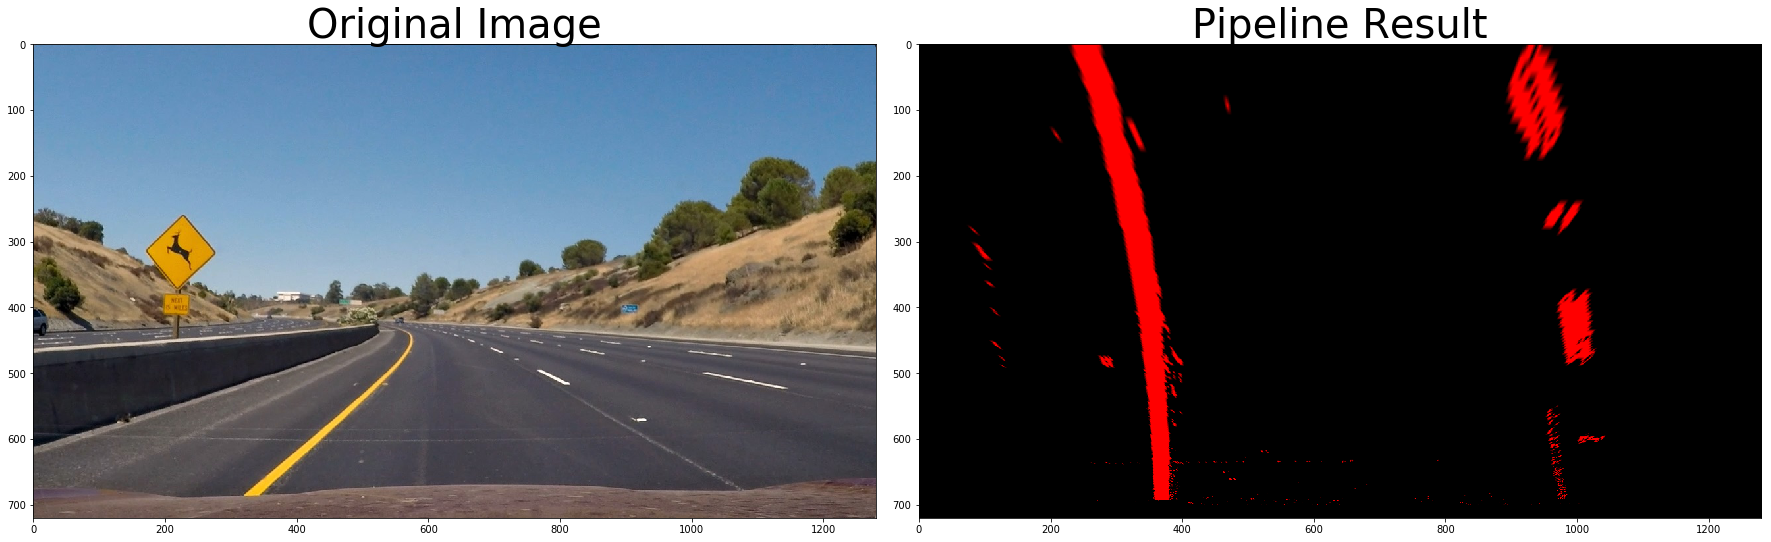

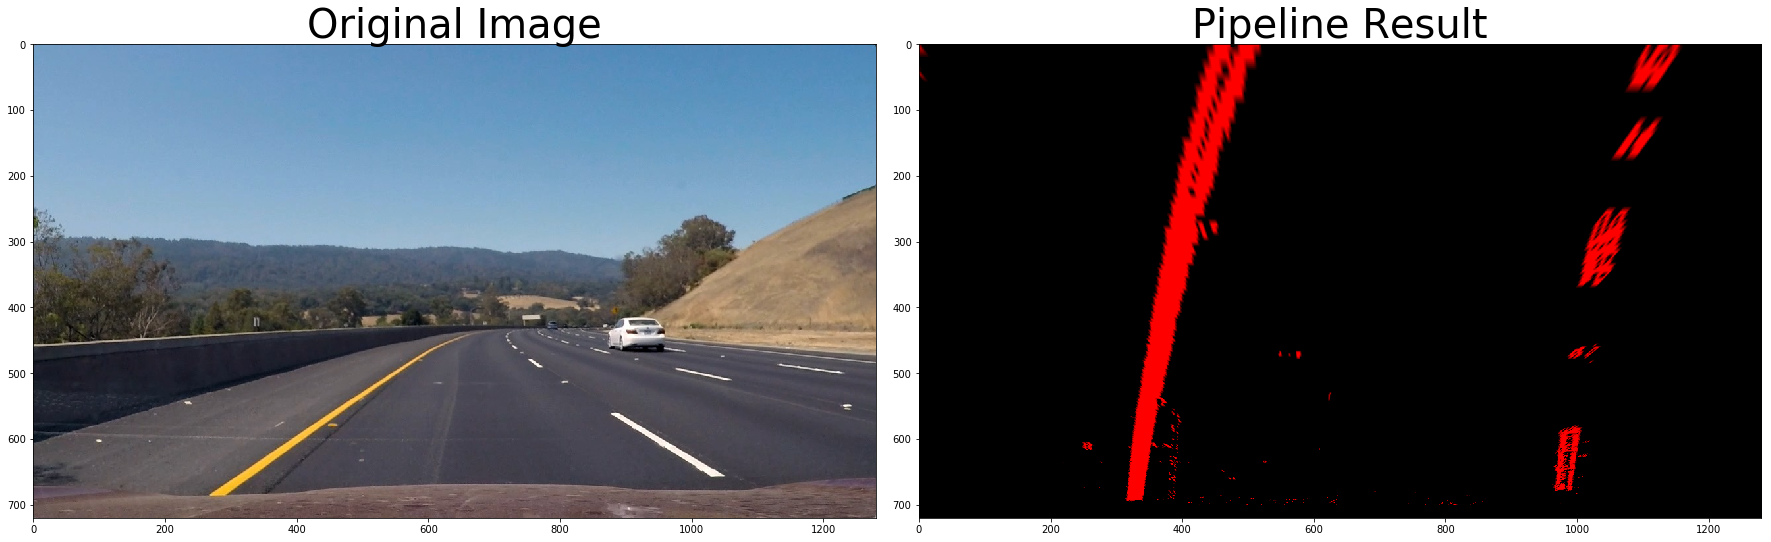

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [89]:
images = glob.glob('./test_images/test*')
img = cv2.imread(images[0])

def process_image(img):
    """That's complete pipeline for processing from original image to warped binary image, ready for finding lines"""
    img = np.copy(img)
    processed = pipeline(img, (190, 255), (20, 150))#[:, :, 2]  # take only first layer that contains best image for finding lines
    # cv2.imwrite('./output_images/processed_start.jpg', img)
    # cv2.imwrite('./output_images/processed.jpg', processed)
    warped = cv2.warpPerspective(processed, M, img_size)
    return warped

# print(img)
# images = glob.glob('./test_images/straight*')
# for fname in images:
#     image = cv2.imread(fname)
for fname in images:
    image = cv2.imread(fname)
    result = process_image(image)
    # fig = plt.figure()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    # cv2.polylines(image, 
    #               [np.array([[195, image.shape[0]], [623, 430], [655, 430], [image.shape[1]-160, image.shape[0]]])],
    #               True,
    #               (0, 0, 255)
    #               )    
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=40)
    
    ax2.imshow(result)
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    print('saving to ./output_images/pipeline_processed_{0}'.format(os.path.basename(fname)))
    plt.savefig('./output_images/pipeline_processed_{0}'.format(os.path.basename(fname)))

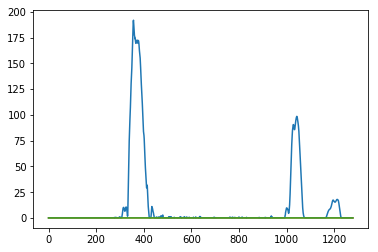

In [90]:
import numpy as np
histogram = np.sum(result[result.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [92]:
image = cv2.rectangle(img, (100,100),(500,200),(0,255,0), 2)
cv2.imshow('test', img)
cv2.waitKey(3000)
cv2.destroyAllWindows()

In [93]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from theano.gof.opt import out2in

binary_warped = result[:,:,0]
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    # cv2.rectangle(out_img,(872, 640),(1072, 720),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
# plt.imshow(out_img)

# f = plt.figure(1, figsize=(16, 9))
# plt.imshow(out_img)
# plt.show()

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

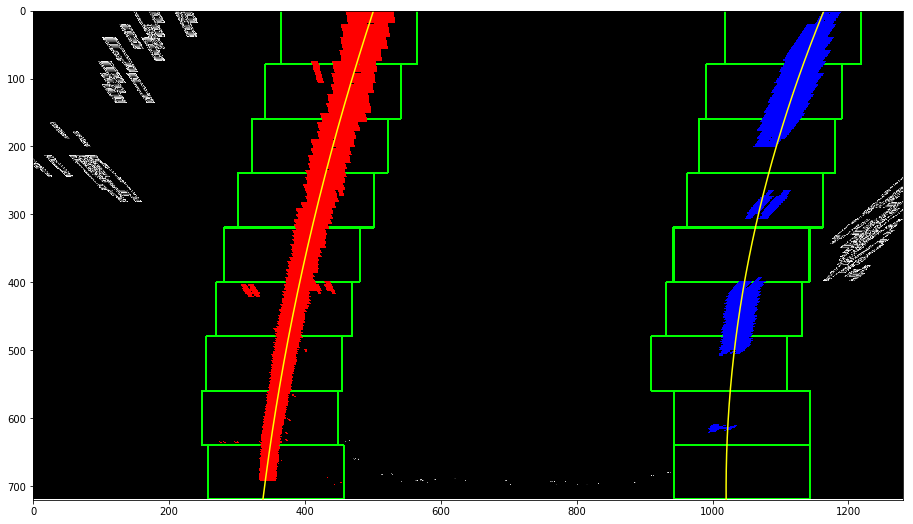

In [94]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
plt.figure(1, figsize=(16, 9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [95]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

True

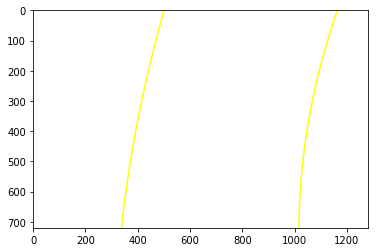

In [96]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# result *= 255

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
# cv2.polylines(result, np.int_([left_fit]), False, (255,255,0))
# plt.imshow(cv2.cvtColor(result, cv2.COLOR_RGB2GRAY))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
cv2.imwrite('./output_images/searched_lines.jpg', result)
# cv2.imwrite('./output_images/searched_lines.jpg', cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR))

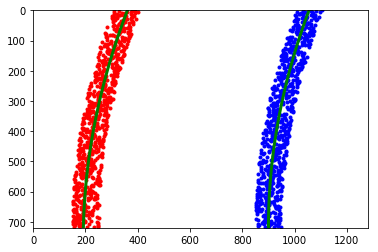

In [97]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [98]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1727.52362825 1662.59421685


In [99]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

566.857353439 m 546.084199493 m


In [100]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)